In [ ]:
# Kernel Density Estimation is a way to estimate smooth distribution of the data based on a set of discrete samples.
#
# The basic idea is to take the moving average of the sample points to smooth it out.
# See https://mathisonian.github.io/kde/ for a nice and interactive demo.

In [5]:
import pandas as pd

showcases_2011 = pd.read_csv("data/showcases.2011.csv", index_col=0, skiprows=[1]).dropna().transpose()
showcases_2011.head(5)

,Showcase 1,Showcase 2,Bid 1,Bid 2,Difference 1,Difference 2
Sep. 19,50969.0,45429.0,42000.0,34000.0,8969.0,11429.0
Sep. 20,21901.0,34061.0,14000.0,59900.0,7901.0,-25839.0
Sep. 21,32815.0,53186.0,32000.0,45000.0,815.0,8186.0
Sep. 22,44432.0,31428.0,27000.0,38000.0,17432.0,-6572.0
Sep. 23,24273.0,22320.0,18750.0,23000.0,5523.0,-680.0


In [18]:
import numpy as np
from scipy.stats import gaussian_kde, norm
from empiricaldist import Pmf

<Axes: >

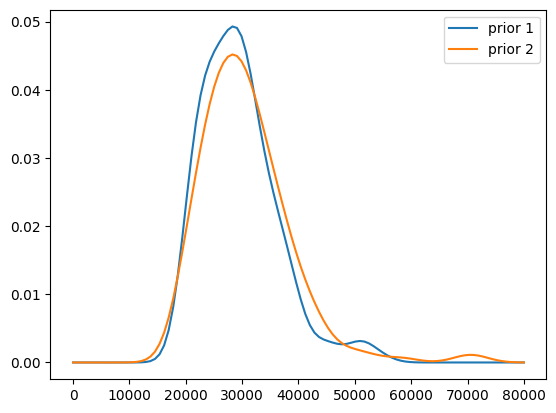

In [12]:
def make_kde(samples, qs):
    kde = gaussian_kde(samples)
    ps = kde(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

qs = np.linspace(0, 80000, 100)
prior1 = make_kde(showcases_2011['Showcase 1'], qs)
prior1.plot(label = "prior 1", legend=True)
prior2 = make_kde(showcases_2011['Showcase 2'], qs)
prior2.plot(label = "prior 2", legend=True)

<Axes: >

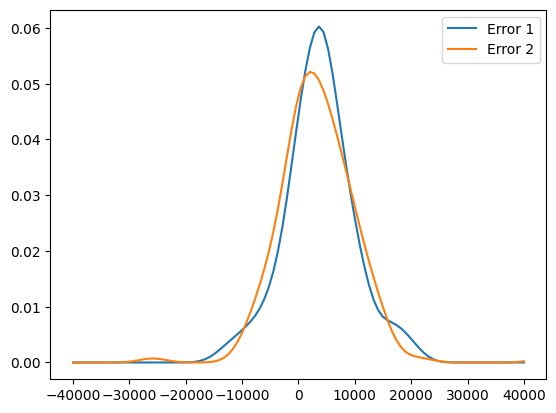

In [16]:
# distribution of error
qs = np.linspace(-40000, 40000, 100)
error1 = make_kde(showcases_2011['Difference 1'], qs)
error2 = make_kde(showcases_2011['Difference 2'], qs)
error1.plot(label = "Error 1", legend=True)
error2.plot(label = "Error 2", legend=True)

In [29]:
# i'm reading directly from the "Difference" column and the sign is opposite to the book. I'm going to keep it this way.
# so negative error = overbidding. 
mean_error1 = error1.mean()
std_error1 = error1.std()

print(mean_error1, std_error1)

3739.0157068062836 6450.422744169068


<Axes: >

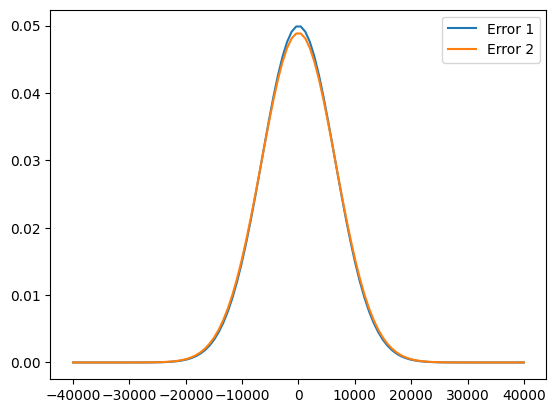

In [31]:
# make a normal distribution based on the mean and stddev
def norm_pmf(mean, std, qs):
    dist = norm(mean, std)
    pmf = Pmf(dist.pdf(qs), qs)
    pmf.normalize()
    return pmf


# the reason we use 0 as mean because we assume the contestants are purposefully underbidding, and their actual estimation would be accurate.
pmf_error1 = norm_pmf(0, error1.std(), qs)
pmf_error2 = norm_pmf(0, error2.std(), qs)

pmf_error1.plot(label = "Error 1", legend=True)
pmf_error2.plot(label = "Error 2", legend=True)

In [ ]:
# suppose you play as player 1, and you estimate the price is 23,000. What's the distribution of the error of your estimation?
def update_guess(prior, guess, error):
    diff = prior - guess # remember: negative = overbidding
    error